## data updates with high frequency for the helioforecast.space website

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

part of https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'


https://github.com/cmoestl/heliocats  data_update_web_hf.py

for updating data with high frequency on the servers

Issues:



In [1]:
#switches
debug_mode=0
#always turn off debug mode when deploying!

#switches to download and save as pickle
get_noaa=1
get_stereoa=1


import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import sys
import numpy as np
import datetime
import scipy.signal
import urllib
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib
import sunpy

from heliocats import data as hd
from heliocats import plot as hp

##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    %matplotlib inline     
    #matplotlib.use('Agg') 



################################################ CHECK  ##############################################

#make sure to convert the current notebook to a script
os.system('jupyter nbconvert --to script data_update_web_hf.ipynb')   


####################################################################################################################

#test execution times
t0all = time.time()


/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


system is mac


[NbConvertApp] Converting notebook data_update_web_hf.ipynb to script
[NbConvertApp] Writing 9474 bytes to data_update_web_hf.py


### Configure paths depending on server or local machine


In [2]:
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import stereoa_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import stereoa_path
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

print(data_path)
print(noaa_path)
print(wind_path)
print(stereoa_path)
print(data_path_ml)


plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)



########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/insitu_python/ML_struct_arrays/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/


### positions and SDO plot

 
------ POSITIONS 
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_2024_Mar_02.png
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.p
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.txt
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.png


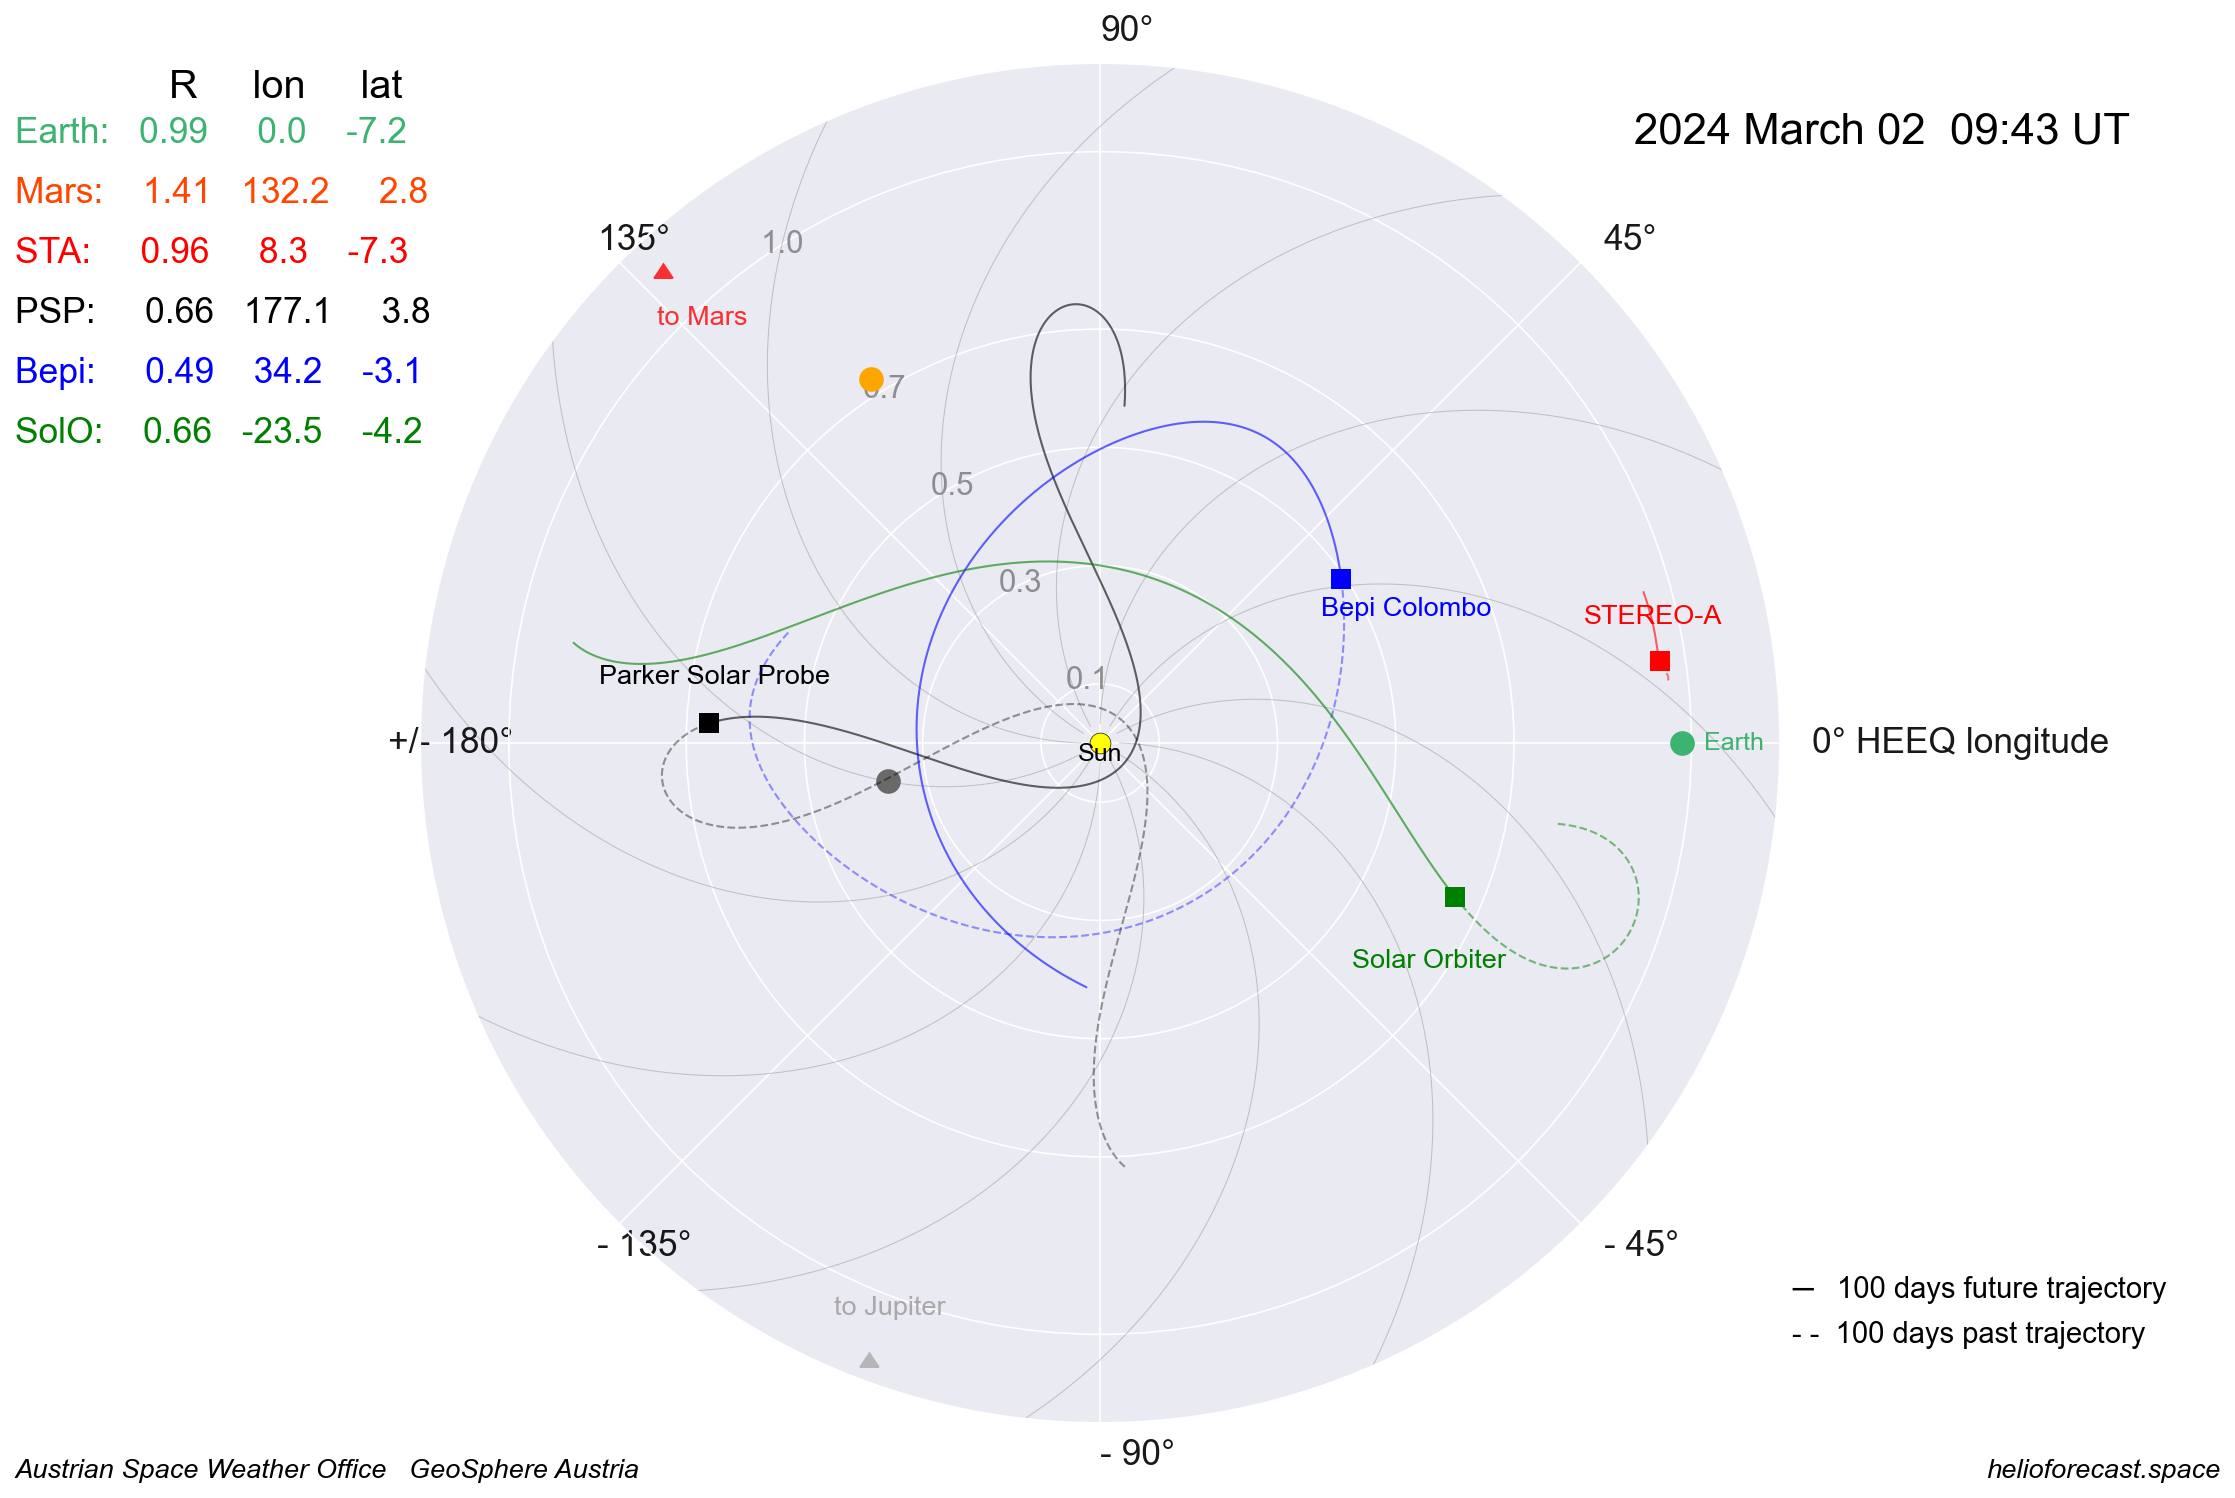

 
------ SDO realtime images 
saved  /Users/chris/python/data/insitu_python/plots_sun/latest_1024_0193.jpg
2024-03-02 09:26 UT


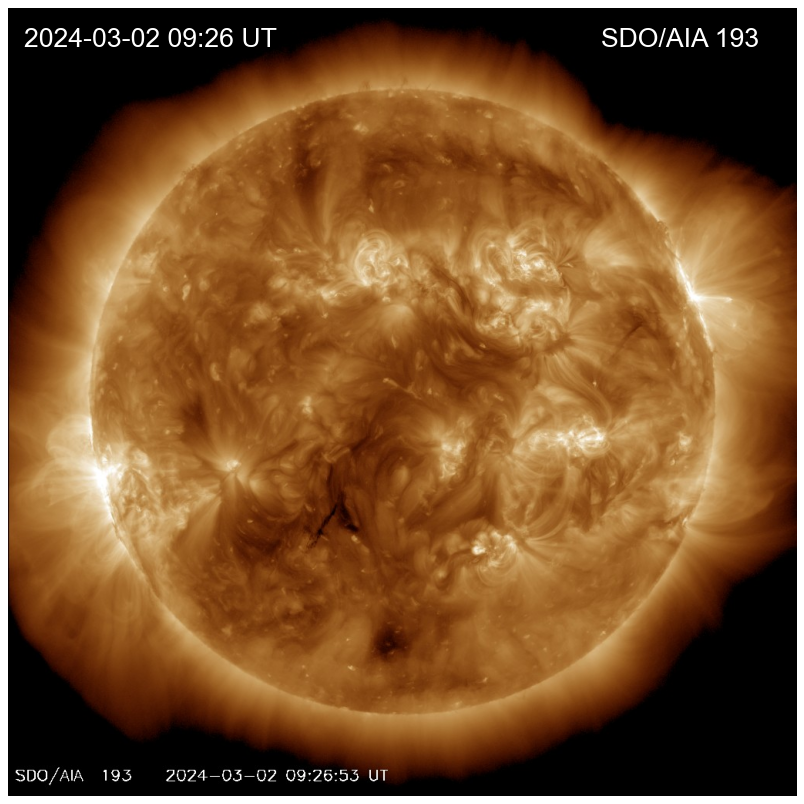

saved  /Users/chris/python/data/insitu_python/plots_sun/latest_1024_HMIB.jpg
2024-03-02 09:15 UT


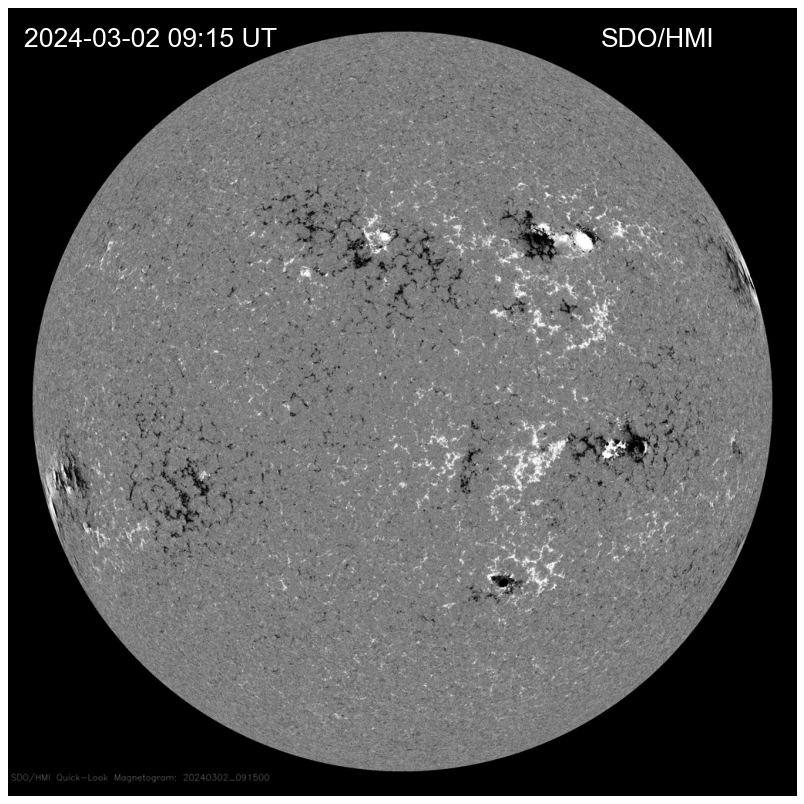


Positions and SDO images takes 21.01 seconds


In [3]:
#if debug_mode > 0: 
importlib.reload(hd) 
importlib.reload(hp) 


t0 = time.time()
print(' ')
print('------ POSITIONS ')

# spacecraft positions image, uses positions file  /results/positions/positions_psp_solo_sta_bepi_wind_planets_HEEQ_10min_rad.p'
hp.plot_positions(datetime.datetime.utcnow(),position_path, 'HEEQ',now=True)


#get NOAA xray file and plot on SDO map
xray='https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json'

#try: 
#    urllib.request.urlretrieve(xray, noaa_path+'xray/xrays-7-day_'+datestr+'.json')
#    print(noaa_path+'xray/xray-7-day_'+datestr+'.json')
#except urllib.error.URLError as e:
#    print(' ', xray,' ',e.reason)



print(' ')
print('------ SDO realtime images ')
# get current SDO images 
hd.get_sdo_realtime_image(sun_path)

t1 = time.time()
print()
print('Positions and SDO images takes', np.round(t1-t0,2), 'seconds')

### NOAA real time solar wind 

 
------ NOAA real time solar wind data 
download NOAA real time solar wind plasma and mag and dst
2024-03-02 UTC
/Users/chris/python/ops/data/noaa/plasma/plasma-7-day_2024-03-02.json
/Users/chris/python/ops/data/noaa/mag/mag-7-day_2024-03-02.json
/Users/chris/python/ops/data/noaa/dst/dst-7-day_2024-03-02.json
NOAA RTSW download complete
 
convert NOAA real time solar wind archive to pickle file
directories for the json data
/Users/chris/python/ops/data/noaa/mag/
Sorted file list to be read with cutoff  35  files. 
['mag-7-day_2023-07-11T12h.json' 'mag-7-day_2023-07-11T13h.json'
 'mag-7-day_2023-07-12T00h.json' 'mag-7-day_2023-07-12T01h.json'
 'mag-7-day_2023-07-12T13h.json' 'mag-7-day_2023-07-13.json'
 'mag-7-day_2023-07-13T00h.json' 'mag-7-day_2023-07-13T01h.json'
 'mag-7-day_2023-07-14.json' 'mag-7-day_2023-07-16.json'
 'mag-7-day_2023-07-18.json' 'mag-7-day_2023-07-21.json'
 'mag-7-day_2023-07-25.json' 'mag-7-day_2023-07-27.json'
 'mag-7-day_2023-08-04.json' 'mag-7-day_2023-08-06.j

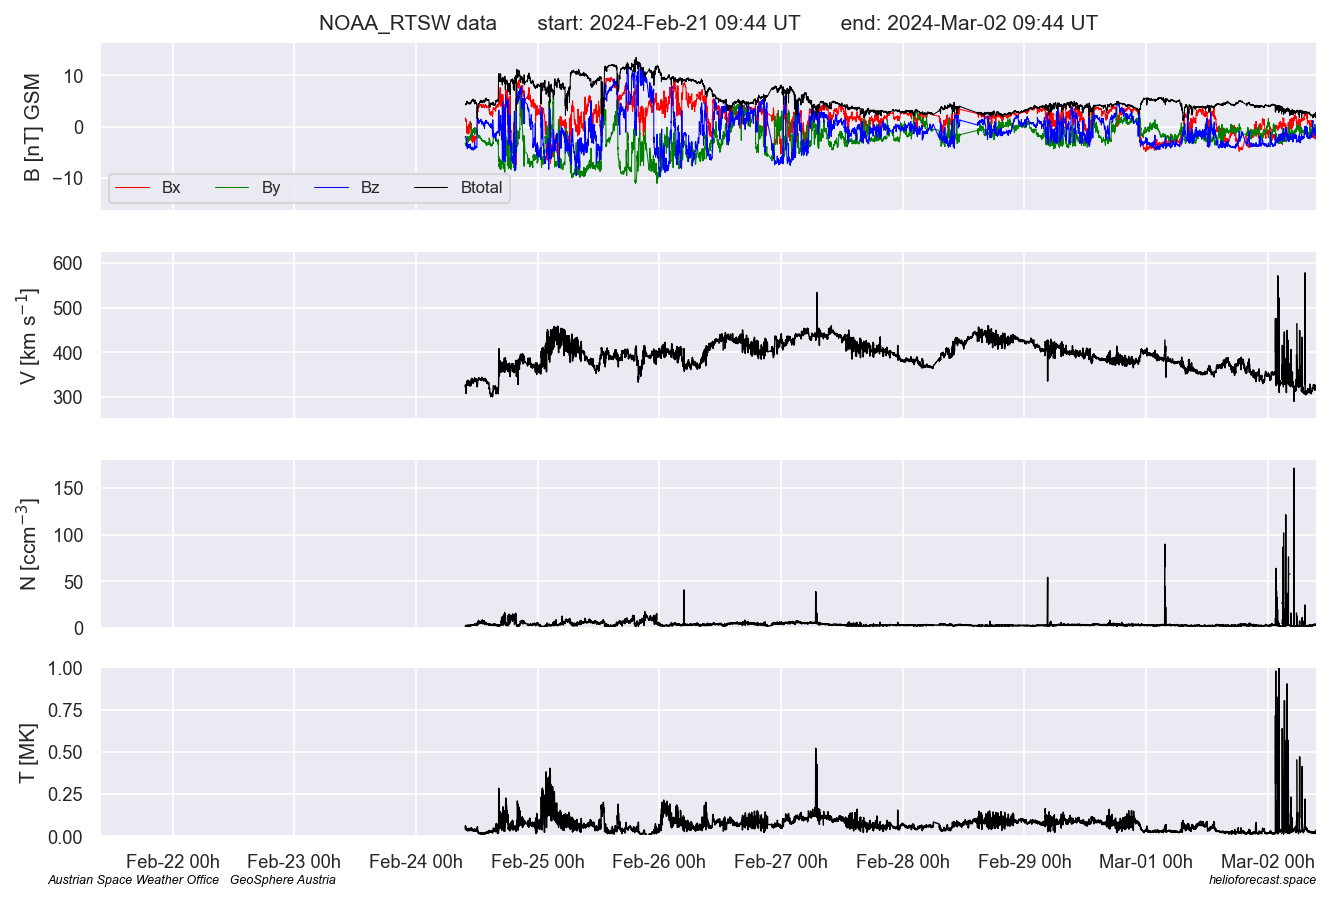

In [4]:
if debug_mode > 0: 
    from heliocats import data as hd
    importlib.reload(hd) 

    from heliocats import plot as hp
    importlib.reload(hp) 

print(' ')
print('------ NOAA real time solar wind data ')

#test execution times
t0 = time.time()

#define file name
filenoaa='noaa_rtsw_last_35files_now.p'
filedst='noaa_dst_last_35files_now.p'


if get_noaa > 0:

    ######## DOWNLOAD NOAA data 
    
    print('download NOAA real time solar wind plasma and mag and dst')
    datestr=str(datetime.datetime.utcnow().strftime("%Y-%m-%d"))
    print(datestr+' UTC')

    #solar wind
    #ephemerides are done with the daily update
    #ephem='http://services.swpc.noaa.gov/products/solar-wind/ephemerides.json' 
    
    plasma='http://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json'
    mag='http://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json'
    
    dst='https://services.swpc.noaa.gov/products/kyoto-dst.json'
        

    #the ephemerides are done with the daily update
    #try: 
    #    urllib.request.urlretrieve(ephem, noaa_path+'ephem/ephemerides_'+datestr+'.json')
    #    print(noaa_path+'ephem/ephemerides_'+datestr+'.json')
    #except urllib.error.URLError as e:
    #    print(' ', ephem,' ',e.reason)

    
    try: 
        urllib.request.urlretrieve(plasma, noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
        print(noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', plasma,' ',e.reason)

    try: 
        urllib.request.urlretrieve(mag, noaa_path+'mag/mag-7-day_'+datestr+'.json')
        print(noaa_path+'mag/mag-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', mag,' ',e.reason)
    
    try: 
        urllib.request.urlretrieve(dst, noaa_path+'dst/dst-7-day_'+datestr+'.json')
        print(noaa_path+'dst/dst-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', dst,' ',e.reason)
        

    print('NOAA RTSW download complete')
        
    ## SAVE NOAA DATA AS PICKLE, dst as extra file
    # last parameter gives a cutoff, so only the latest N files are taken for the NOAA data pickle file
    
    
    if debug_mode == 0: hd.save_noaa_rtsw_data(data_path,noaa_path,filenoaa,filedst,35)
    if debug_mode > 0: hd.save_noaa_rtsw_data(data_path,noaa_path,filenoaa,filedst,3)

    print('NOAA RTSW saved as pickle file complete')
    

else:
    print('NOAA data NOT downloaded and saved as pickle, turn on switch')  


#load data file
[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 

#load dst file
#dst=pickle.load(open(data_path+filedst, "rb" ) ) 

 
#plot
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_noaa_rtsw(noaa, start, end,'NOAA_RTSW',plot_path+'noaa/',now=True)


t1 = time.time()

print('-----done')

print()
print('NOAA download latest file, save as pickle last 35 files and plotting takes', np.round(t1-t0,2), 'seconds')

#plt.plot(dst.time,dst.dst)

### STEREO-A beacon data

 
------ STEREO-A beacon data 
 
--- download STEREO-A beacon data last 10 days 
download STEREO-A beacon data to  /Users/chris/python/data/stereoa/
STA_LB_IMPACT_20240221_V02.cdf
STA_LB_PLASTIC_20240221_V14.cdf
STA_LB_IMPACT_20240222_V02.cdf
STA_LB_PLASTIC_20240222_V14.cdf
STA_LB_IMPACT_20240223_V02.cdf
STA_LB_PLASTIC_20240223_V14.cdf
STA_LB_IMPACT_20240224_V02.cdf
STA_LB_PLASTIC_20240224_V14.cdf
STA_LB_IMPACT_20240225_V02.cdf
STA_LB_PLASTIC_20240225_V14.cdf
STA_LB_IMPACT_20240226_V02.cdf
STA_LB_PLASTIC_20240226_V14.cdf
STA_LB_IMPACT_20240227_V02.cdf
STA_LB_PLASTIC_20240227_V14.cdf
STA_LB_IMPACT_20240228_V02.cdf
STA_LB_PLASTIC_20240228_V14.cdf
STA_LB_IMPACT_20240229_V02.cdf
STA_LB_PLASTIC_20240229_V14.cdf
STA_LB_IMPACT_20240301_V02.cdf
STA_LB_PLASTIC_20240301_V14.cdf
STA_LB_IMPACT_20240302_V02.cdf
STA_LB_PLASTIC_20240302_V14.cdf
 
--- process STEREO-A beacon data to pickle last 35 days
2024-01-27 09:44:00
2024-03-02 09:44:00
['20240127', '20240128', '20240129', '20240130', '20240131',

100.0% 3129344 / 3123200


100.0% 3170304 / 3163136


100.0% 1089536 / 1088512


100.0% 983040 / 975872


position end 
conversion RTN to GSE
conversion RTN to GSE done
conversion GSE to GSM
conversion GSE to GSM done
save pickle file
save pickle file
done sta
saved as  /Users/chris/python/data/insitu_python/plots/stereoa/STEREO-A_beacon_rtn_2024_Feb_21_2024_Mar_02.png
saved as  /Users/chris/python/data/insitu_python/plots/stereoa/STEREO-A_beacon_rtn_now.png
saved as  /Users/chris/python/data/insitu_python/plots/stereoa/STEREO-A_beacon_gsm_2024_Feb_21_2024_Mar_02.png
saved as  /Users/chris/python/data/insitu_python/plots/stereoa/STEREO-A_beacon_gsm_now.png

STEREO-A beacon downloading last 10 days, save as pickle last 35 days and plotting takes 57.79 seconds


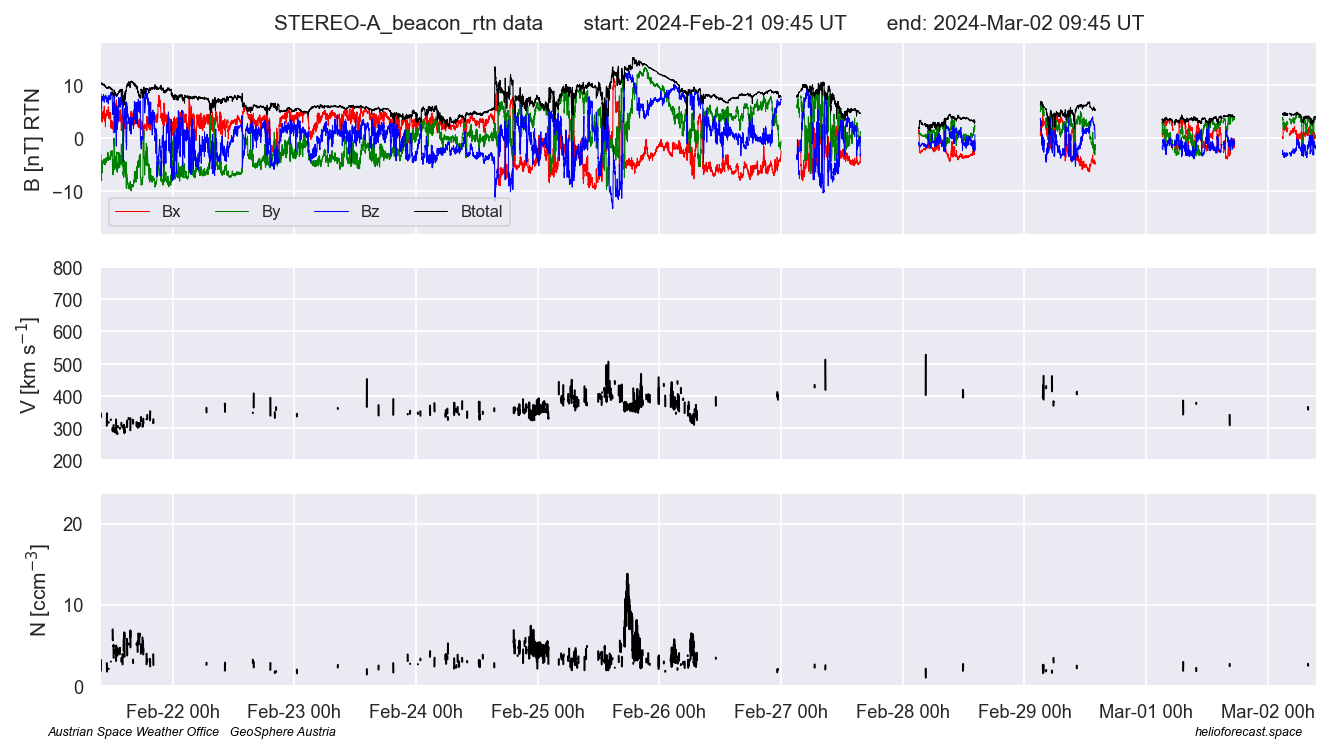

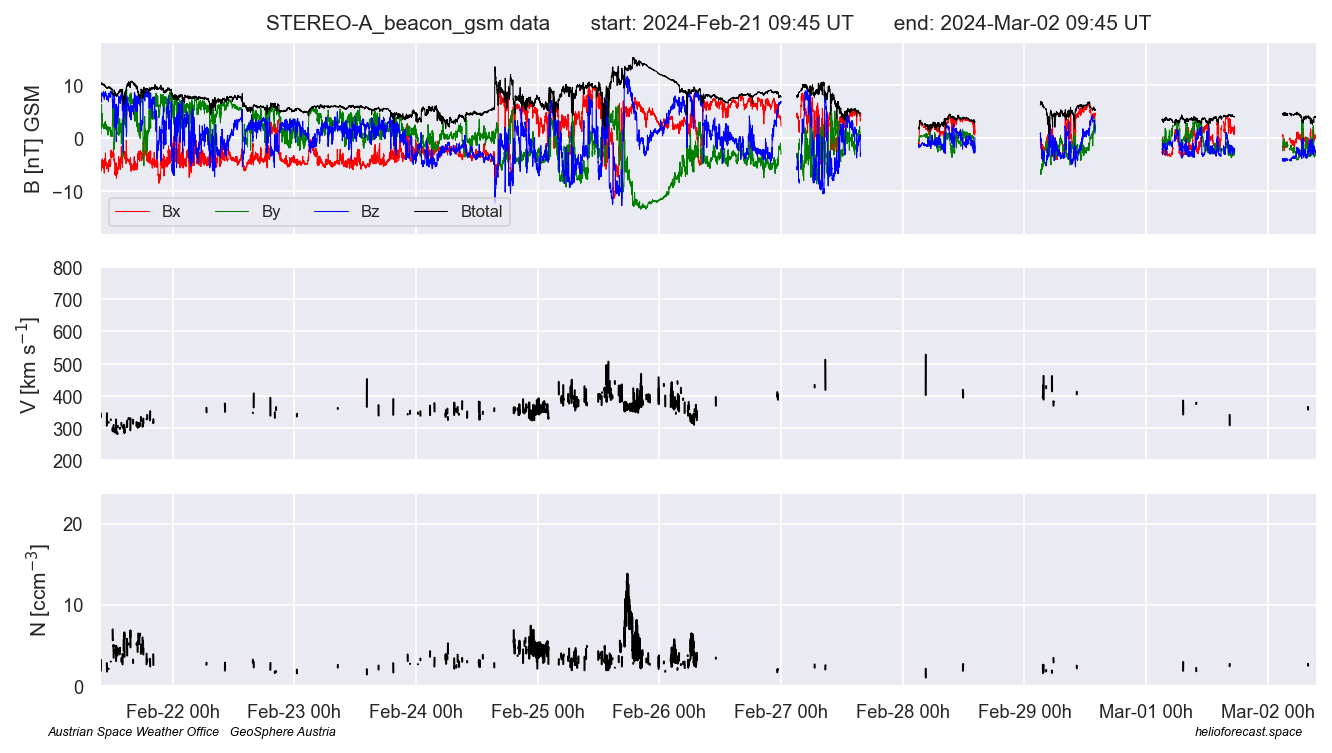

In [5]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

#test execution times
t0 = time.time()

print(' ')
print('------ STEREO-A beacon data ')

#define filename
file_sta_beacon_rtn='stereoa_beacon_rtn_last_35days_now.p'   
file_sta_beacon_gsm='stereoa_beacon_gsm_last_35days_now.p'   

if get_stereoa > 0:

    print(' ')
    print('--- download STEREO-A beacon data last 10 days ')
    hd.stereoa_download_beacon(start=datetime.datetime.utcnow()-datetime.timedelta(days=10),end=datetime.datetime.utcnow(),stereoa_path=stereoa_path)   
    print(' ')

    print('--- process STEREO-A beacon data to pickle last 35 days') 
    #save pickle file
    hd.save_stereoa_beacon_data(data_path,stereoa_path,file_sta_beacon_rtn,file_sta_beacon_gsm,datetime.datetime.utcnow()-datetime.timedelta(days=35),datetime.datetime.utcnow(),coord='RTN' )   
    
    
#load rtn
[sta_rtn,hsta]=pickle.load(open(data_path+file_sta_beacon_rtn, "rb" ) )  
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_stereoa_beacon(sta_rtn, start, end,'STEREO-A_beacon_rtn',plot_path+'stereoa/',coord='RTN',now=True)


#load gsm
[sta_gsm,hsta]=pickle.load(open(data_path+file_sta_beacon_gsm, "rb" ) )  
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 


hp.plot_insitu_update_stereoa_beacon(sta_gsm, start, end,'STEREO-A_beacon_gsm',plot_path+'stereoa/',coord='GSM',now=True)


    
    
t1 = time.time()

print()
print('STEREO-A beacon downloading last 10 days, save as pickle last 35 days and plotting takes', np.round(t1-t0,2), 'seconds')

## Combined plot STEREO-A NOAA RTSW

saved as  /Users/chris/python/data/insitu_python/plots/combined/NOAA_RTSW_STEREO-A_beacon_2024_Feb_28_2024_Mar_02.png
saved as  /Users/chris/python/data/insitu_python/plots/combined/NOAA_RTSW_STEREO-A_beacon_now.png


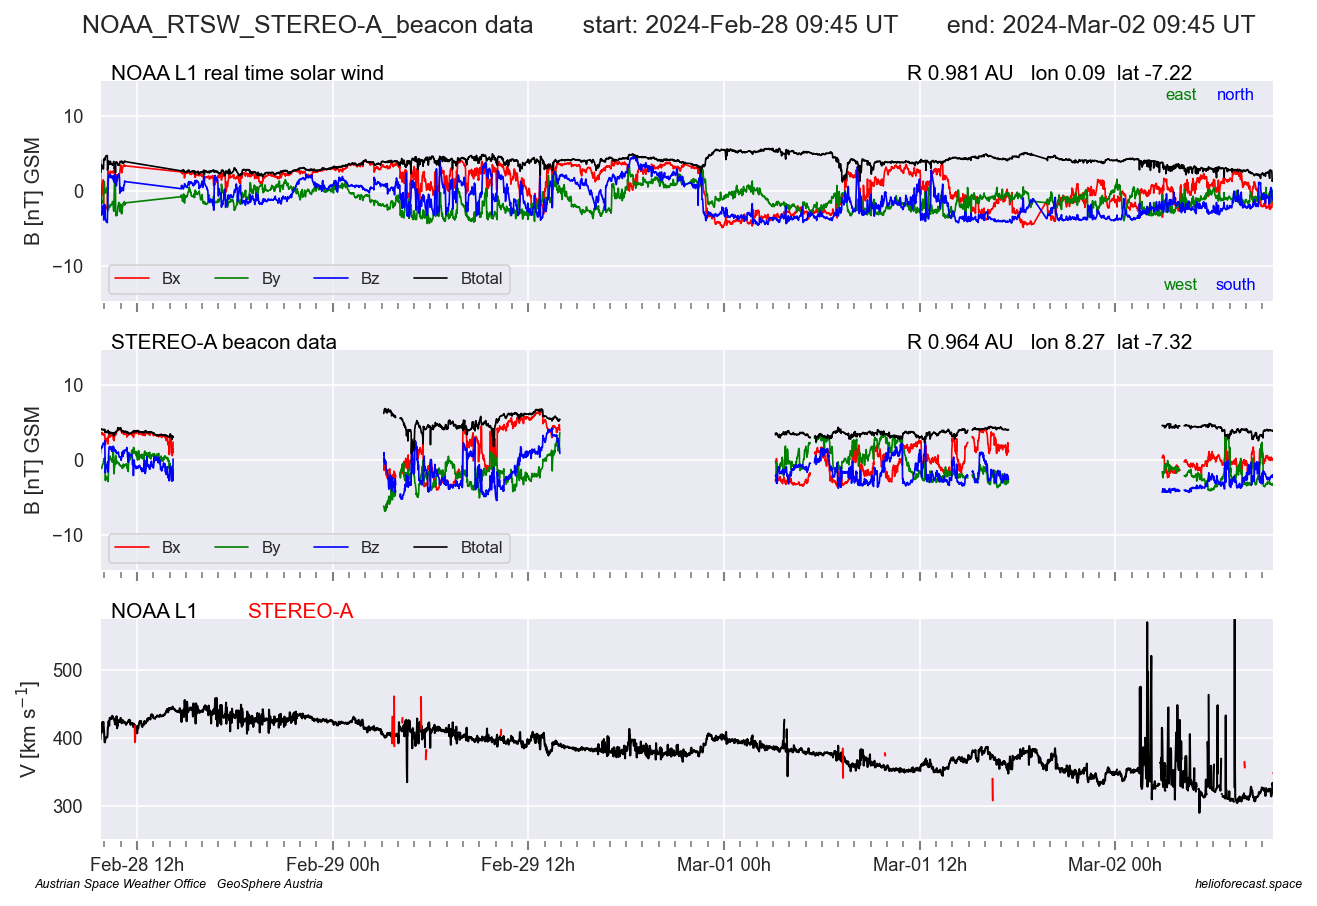

In [6]:

debug_mode=1
if debug_mode > 0:     
    importlib.reload(hd) 
    importlib.reload(hp) 

start=datetime.datetime.utcnow() - datetime.timedelta(days=3)
end=datetime.datetime.utcnow()
hp.plot_insitu_update_stereoa_noaa(noaa, sta_gsm, start, end,'NOAA_RTSW_STEREO-A_beacon',plot_path+'combined/',now=True)
    

In [7]:
t1all = time.time()

print(' ')
print(' ')
print(' ')
print('------------------')
print('Runtime for full high frequency data update:', np.round((t1all-t0all),2), 'seconds')
print('--------------------------------------------------------------------------------------')

 
 
 
------------------
Runtime for full high frequency data update: 141.74 seconds
--------------------------------------------------------------------------------------
